In [1]:
# !git clone https://github.com/hyperforest/seisbench.git
# !pip install -e seisbench

In [54]:
import numpy as np
from pathlib import Path as _Path
from torchsummary import summary
import torch
import seaborn as sns

%load_ext autoreload
%autoreload 2
import seisbench
import seisbench.data as sbd
import seisbench.models as sbm
import seisbench.generate as sbg
import matplotlib.pyplot as plt
import copy
from utils import Solver, ProbabilisticLabeller
from blocks import *
import logging
from leqnet import LEQNet

seisbench.cache_root = _Path("../")
seisbench.cache_data_root = _Path("../datasets/")
seisbench.cache_model_root = seisbench.cache_root / 'models' / 'v3'
# seisbench.remote_model_root = 'https://dcache-demo.desy.de:2443/Helmholtz/HelmholtzAI/SeisBench/models/v3/'
# seisbench.config = {'dimension_order': 'NCW', 'component_order': 'ZNE'}
# seisbench.__version__ = '0.5.2'

# logger = logging.getLogger('seisbench')
# logger.setLevel(logging.INFO)
# seisbench.logger = logger


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [55]:
data = sbd.Iquique(sampling_rate=100)
df_meta = data.metadata
mask = (~df_meta['trace_P_arrival_sample'].isna() &
        ~df_meta['trace_S_arrival_sample'].isna())

data.filter(mask)

train, val, test = data.train_dev_test()

train_generator = sbg.GenericGenerator(train)
val_generator = sbg.GenericGenerator(val)
test_generator = sbg.GenericGenerator(test)


2024-01-12 10:26:39,364 | seisbench | WARNING | Check available storage and memory before downloading and general use of Iquique dataset. Dataset size: waveforms.hdf5 ~5Gb, metadata.csv ~2.6Mb


1719


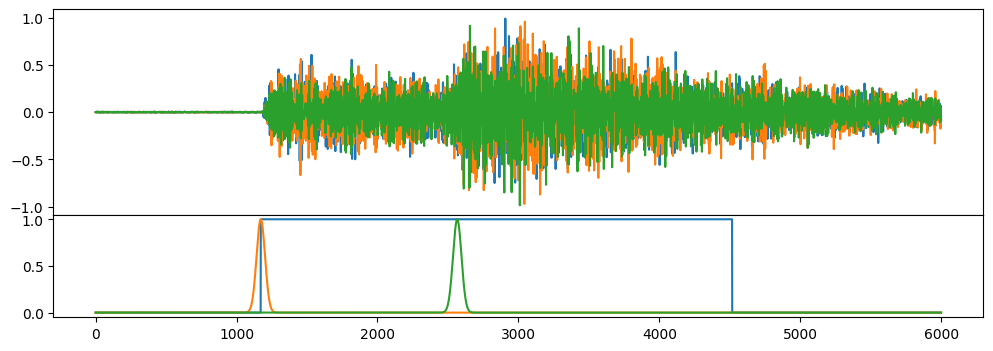

In [56]:
phase_dict = {
    "trace_P_arrival_sample": "P",
    "trace_S_arrival_sample": "S"
}

preprocessing = [
    sbg.RandomWindow(windowlen=6000, strategy="move"),
    sbg.Normalize(demean_axis=-1, detrend_axis=-1, amp_norm_axis=-1, amp_norm_type="peak"),
    sbg.Filter(btype='bandpass', Wn=[2,25], N=6),
    sbg.ChangeDtype(np.float32),
    ProbabilisticLabeller(label_columns=phase_dict, sigma=30, dim=1, use_detection=True, spectrogram_based=False)
]
train_augmentation = [
    sbg.WindowAroundSample(list(phase_dict.keys()), samples_before=2000, windowlen=8000, selection="first", strategy="pad"),
    *preprocessing,
]

# meniadakan augmentasi random window untuk data pengujian
test_preprocessing = [
    sbg.WindowAroundSample(list(phase_dict.keys()), samples_before=2000, windowlen=6000, selection="first", strategy="pad"),
    *preprocessing,
]

train_generator.add_augmentations(train_augmentation)
val_generator.add_augmentations(train_augmentation)
test_generator.add_augmentations(test_preprocessing)

n = np.random.randint(len(train_generator))
# n=1175
print(n)
sample = train_generator[n]

fig = plt.figure(figsize=(12, 4))
axs = fig.subplots(2, 1, sharex=True, gridspec_kw={"hspace": 0, "height_ratios": [2, 1]})
axs[0].plot(sample["X"].T)
axs[1].plot(sample["y"].T)
plt.show()

In [68]:
pt_data = "iquique"
pt_file = seisbench.cache_model_root / 'eqtransformer' / f'{pt_data}.pt.v2'

# model_pt = sbm.EQTransformer.from_pretrained(pt_data, update=True)
model_base = sbm.EQTransformer()
weight_path, metadata_path = model_base._pretrained_path(pt_data, '2')
model_base._ensure_weight_files(pt_data, '2', weight_path, metadata_path, False, False)
model_pt = model_base.load(weight_path.with_name(pt_data), version_str='2')

model_eqt = sbm.EQTransformer()
model_leq = LEQNet()
model_leq.update_attributes()
model_leq_plus = LEQNet()
model_leq_plus.update_attributes(modified=True)

# adding up weight of bilstm
for model in [model_leq_plus, model_leq, model_eqt]:
  model.bi_lstm_stack = model_pt.bi_lstm_stack
  for name, param in model.named_parameters():
    if 'lstm' in name:
      param.requires_grad = False

In [69]:
version = 2
models = [
  # dict(name='LEQNet+', selected=model_leq_plus),
  # dict(name='LEQNet', selected=model_leq),
  dict(name='EQTransformer', selected=model_eqt),
]

for bs in [32]:
  for lr in [1e-3]:
    for model in models:
      folder_name = f'{pt_data}/v{version}_{model["name"]}_bs{bs}_lr{lr}'
      model = copy.deepcopy(model['selected']).to(device='cuda')

      config = dict(
        main = dict(
          batch_size=bs, 
          folder_name=folder_name,
          model= model, 
          class_weights=[.02, .40, .58],
          patience=50,
          ),
        train = dict (
          learning_rate=lr,
          epochs=50,
          print_every_batch=20,
        ),
        test = dict(
          model_path=folder_name,
          model_base=model,
          plot_batch_id=[i for i in range(bs)],
          dT=400
        )
      )

      solver = Solver(train_generator, val_generator, test_generator, **config['main'])
      # solver.train(**config['train'])
      solver.test(**config['test'])
      # solver.plot_hist(model)


c:\eq-detection\.venv\Lib\site-packages\torch\nn\modules\rnn.py:879: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ..\aten\src\ATen\native\cudnn\RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


[test] loss: 0.032239 | loss_d: 0.174441 | loss_p: 0.026270 | loss_s: 0.031452 | f1_d: 0.953244 | f1_p: 0.734563 | f1_s: 0.627611


Saving plot..:   1%|          | 1/108 [00:06<11:18,  6.34s/it]c:\eq-detection\.venv\Lib\site-packages\torch\nn\modules\rnn.py:879: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ..\aten\src\ATen\native\cudnn\RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
Saving plot..:   2%|▏         | 2/108 [00:06<05:16,  2.99s/it]c:\eq-detection\.venv\Lib\site-packages\torch\nn\modules\rnn.py:879: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ..\aten\src\ATen\native\cudnn\RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, s

In [40]:
for model in [model_eqt, model_leq_plus]:
    print((model.in_channels, model.in_samples))

(3, 6000)
(3, 6000)


In [ ]:
from thop import profile

input_size = (32, 3, 6000)
input_data = torch.randn(*input_size).to('cuda')

profile(model, inputs=(input_data,))

In [72]:
import json
from scipy import stats
import statsmodels.api as sm
import pandas as pd

def snr_dist_compare(paths, model_label, dT=500):
  fig, axs = plt.subplots(1,3, figsize=(12,4))
  colors = ['red', 'slateblue', 'blue']
  data_means = []
  data_normality = []
  for p,path in enumerate(paths):
    with open(path/f'test_dT{dT}'/'dist_SNR.json', 'r') as f:
      data = json.load(f)
    mean_values = []
    norm_values = []
    for i,label in enumerate(['p', 's', 'd']):
      selected_data = np.array(data[label])
      if p>0: selected_data = selected_data[-mask:]
      
      statistic, p_value = stats.shapiro(selected_data)
      mean = np.mean(selected_data)
      sns.histplot(selected_data, ax=axs[i], bins=50, alpha=0.07, kde=True, stat='frequency', color=colors[p], label=model_label[p]+f' ({statistic:.3f})', edgecolor=None)
      axs[i].axvline(mean, color=colors[p], linewidth=1, linestyle='dashed')
      
      title = 'Pick P' if label=='p' else 'Pick S' if label=='s' else 'Pick CODA'
      axs[i].set_title(title)
      axs[i].set_xlabel('SNR db')
      handles, labels = axs[i].get_legend_handles_labels()
      axs[i].legend(handles, labels)
      axs[i].set_xlim(0,60) if 'd' != label else axs[i].set_xlim(-20,2)
      
      mean_values.append(f"{mean:.2f}")
      norm_values.append(f"{p_value:.5f}")

    data_means.append(mean_values)
    data_normality.append(norm_values)
    
    if p==0: mask = len(selected_data)
    print(len(selected_data))

  plt.tight_layout()
  plt.savefig(f'snr_compare_dT{dT}.png')
  df = pd.DataFrame(data_means, columns=['Pick P', 'Pick S', 'Pick CODA'], index=model_label)
  df2 = pd.DataFrame(data_normality, columns=['Pick P', 'Pick S', 'Pick CODA'], index=model_label)
  print('Mean of SNR Distribution')
  display(df)

  print('Normality P-value using Shapiro-Wilk test')
  display(df2)

path1 = _Path('outputs/iquique/v2_EQTransformer_bs32_lr0.001')
path2 = _Path('outputs/iquique/v3_LEQNet_bs32_lr0.001')
path3 = _Path('outputs/iquique/v3_LEQNet+_bs32_lr0.001')

snr_dist_compare([path1, path2, path3], ['EQTransformer', 'LEQNet', 'LEQNet+'], 400)

1874
1874
1874
Mean of SNR Distribution


,Pick P,Pick S,Pick CODA
EQTransformer,33.91,11.84,-3.03
LEQNet,30.40,11.08,-3.84
LEQNet+,27.35,11.26,-3.72


Normality P-value using Shapiro-Wilk test


,Pick P,Pick S,Pick CODA
EQTransformer,0.00000,0.00000,0.00000
LEQNet,0.00008,0.00001,0.00000
LEQNet+,0.00000,0.03888,0.48490
